# Lokta-Volterra

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/MicroCanonicalHMC.jl/examples`


In [2]:
using Turing
using DifferentialEquations
using LinearAlgebra
using PyPlot

# Set a seed for reproducibility.
using Random
Random.seed!(14)

using Revise
using MicroCanonicalHMC

# PDE-Modelling

In [3]:
# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end

# Define initial-value problem.
u0 = [1.0, 1.0]
p = [1.5, 1.0, 3.0, 1.0]
tspan = (0.0, 10.0)
prob = ODEProblem(lotka_volterra, u0, tspan, p);

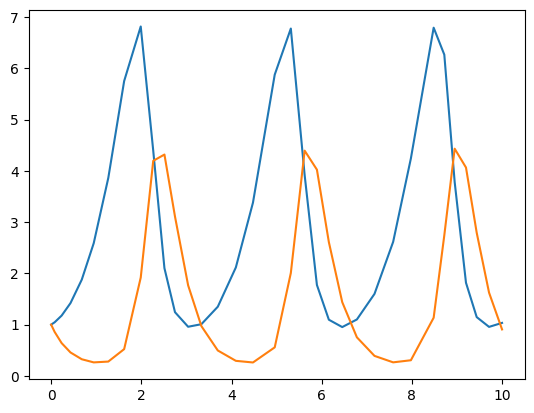

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1385aeea30>

In [4]:
sol = solve(prob, Tsit5())
u_1 = [u[1] for u in sol.u]
u_2 = [u[2] for u in sol.u]
plt.plot(sol.t, u_1)
plt.plot(sol.t, u_2)

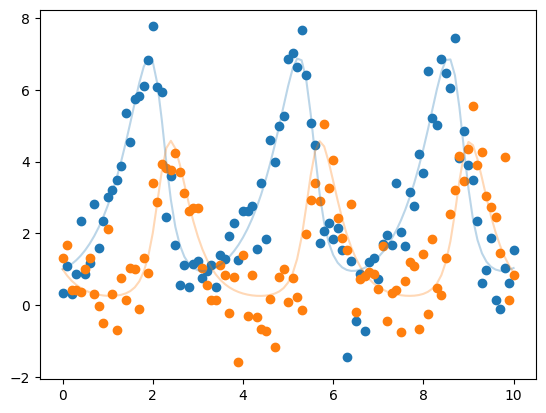

PyObject <matplotlib.collections.PathCollection object at 0x7f135571f3a0>

In [5]:
sol = solve(prob, Tsit5(); saveat=0.1)
u_1 = [u[1] for u in sol.u]
u_2 = [u[2] for u in sol.u]
odedata = Array(sol) + 0.8 * randn(size(Array(sol)))
odedata[1, :]
# Plot simulation and noisy observations.
plt.plot(sol.t, u_1; alpha=0.3)
plt.plot(sol.t, u_2; alpha=0.3)
plt.scatter(sol.t, odedata[1, :]; label="")
plt.scatter(sol.t, odedata[2, :]; label="")

In [6]:
@model function fitlv(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5), 0.5, 2.5)
    β ~ truncated(Normal(1.2, 0.5), 0, 2)
    γ ~ truncated(Normal(3.0, 0.5), 1, 4)
    δ ~ truncated(Normal(1.0, 0.5), 0, 2)

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    predicted = solve(prob, Tsit5(); p=p, saveat=0.1)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

model = fitlv(odedata, prob);

## MCHMC

In [7]:
target = TuringTarget(model);

In [8]:
spl = MCHMC(10_000, 0.01; sigma=ones(target.d), adaptive=true)
samples_mchmc = Sample(spl, target, 100_000; dialog=true);

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):   0%|                                   |  ETA: 0:43:23

Burn in step: 2000
eps --->0.022148461099514002
L   --->0.0029840117309670234
 
Burn in step: 4000
eps --->0.019309345092464705
L   --->0.002024235742516763
 
Burn in step: 6000
eps --->0.02286034915428596
L   --->0.0021576394559345733
 
Burn in step: 8000
eps --->0.019008265973824386
L   --->0.0017062899635110788
 


Burn in step: 10000
eps --->0.018229739038800433
L   --->0.0017953984893109129
 


[ Info: eps: 0.018229739038800433
[ Info: L: 0.0017953984893109129
[ Info: nu: 19518.674406710194
[ Info: sigma: [1.0, 1.0, 1.0, 1.0, 1.0]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:22

In [9]:
σ_mchmc = [sample[1] for sample in samples_mchmc]
α_mchmc = [sample[2] for sample in samples_mchmc] 
β_mchmc = [sample[3] for sample in samples_mchmc]  
γ_mchmc = [sample[4] for sample in samples_mchmc]
δ_mchmc = [sample[5] for sample in samples_mchmc];

In [10]:
ESSs, rhat = Summarize(samples_mchmc)
ESS = mean(ESSs)
ESS

36405.492047374166

## NUTS

In [ ]:
# Sample 3 independent chains with forward-mode automatic differentiation (the default).
samples_hmc = sample(model, NUTS(0.65), 5000; progress=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:39


In [ ]:
σ_hmc = vec(samples_hmc["σ"])
α_hmc = vec(samples_hmc["α"])
β_hmc = vec(samples_hmc["β"]) 
γ_hmc = vec(samples_hmc["γ"])
δ_hmc = vec(samples_hmc["δ"]);

## Comp

In [ ]:
fig, axis = plt.subplots(3, 2, figsize=(8,10))
fig.suptitle("Lotka-Volterra's Comp.", fontsize=16)

fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(σ_hmc, bins=100, density=true, alpha = 0.3, label="NUTS")
axis[1,1].hist(σ_mchmc, bins=100, density=true, alpha = 0.3, label="MCHMC")
axis[1,1].legend()
axis[1,1].set_xlabel("σ")
axis[1,1].set_yticks([])

axis[1,2].hist(β_hmc, bins=100, density=true, alpha = 0.3)
axis[1,2].hist(β_mchmc, bins=100, density=true, alpha = 0.3)
axis[1,2].set_xlabel("β")
axis[1,2].set_yticks([])

axis[2,1].hist(γ_hmc, bins=100, density=true, alpha = 0.3)
axis[2,1].hist(γ_mchmc, bins=100, density=true, alpha = 0.3)
axis[2,1].set_xlabel("γ")
axis[2,1].set_yticks([])

axis[2,2].hist(α_hmc, bins=100, density=true, alpha = 0.3)
axis[2,2].hist(α_mchmc, bins=100, density=true, alpha = 0.3)
axis[2,2].set_xlabel("α")
axis[2,2].set_yticks([])

axis[3,1].hist(δ_hmc, bins=100, density=true, alpha = 0.3)
axis[3,1].hist(δ_mchmc, bins=100, density=true, alpha = 0.3)
axis[3,1].set_xlabel("δ")
axis[3,1].set_yticks([])

axis[3,2].axis("off")